In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [47]:
import os
import cv2
import pandas as pd
import numpy as np

data_path = './data3'

chars = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'K': 9,
    'L': 10,
    'M': 11,
    'N': 12,
    'O': 13,
    'P': 14,
    'Q': 15,
    'R': 16,
    'S': 17,
    'T': 18,
    'U': 19,
    'V': 20,
    'W': 21,
    'X': 22,
    'Y': 23
}

labels_path = [os.path.join(data_path, label_path) for label_path in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, label_path))]
data_paths = [(label_path, os.path.join(label_path, image_path)) for label_path in labels_path for image_path in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, image_path))]

data = [(chars[label_path[-1]], cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (28, 28), interpolation = cv2.INTER_AREA)) for label_path, image_path in data_paths]
data = pd.DataFrame(data)
train_data = data.groupby(0).apply(lambda x: x.sample(min(len(x), 150), random_state=1)).reset_index(drop=True)
test_data = data[~data.iloc[:, 1].isin(train_data.iloc[:, 1])]

In [48]:
train_data

,0,1
0,0,"[[137, 143, 147, 150, 152, 154, 155, 157, 158,..."
1,0,"[[136, 136, 137, 138, 139, 140, 140, 141, 142,..."
2,0,"[[152, 153, 155, 156, 158, 159, 160, 162, 164,..."
3,0,"[[150, 151, 152, 154, 155, 156, 158, 159, 161,..."
4,0,"[[118, 118, 119, 119, 120, 120, 121, 122, 122,..."
...,...,...
3514,23,"[[97, 118, 144, 135, 133, 131, 132, 138, 143, ..."
3515,23,"[[92, 91, 93, 94, 97, 100, 104, 107, 110, 113,..."
3516,23,"[[119, 120, 120, 120, 120, 120, 120, 120, 120,..."
3517,23,"[[196, 153, 104, 84, 149, 136, 135, 133, 137, ..."


In [49]:
test_data

,0,1
7,0,"[[138, 143, 148, 152, 155, 156, 158, 159, 160,..."
20,0,"[[152, 154, 155, 157, 157, 159, 160, 162, 164,..."
25,0,"[[143, 145, 149, 153, 154, 156, 157, 158, 160,..."
37,0,"[[136, 137, 139, 138, 140, 140, 141, 142, 142,..."
50,0,"[[138, 139, 140, 140, 141, 140, 141, 143, 144,..."
...,...,...
3981,23,"[[108, 106, 106, 105, 104, 104, 105, 105, 106,..."
3983,23,"[[128, 129, 130, 132, 132, 134, 135, 136, 136,..."
3993,23,"[[114, 115, 115, 115, 116, 117, 117, 118, 118,..."
3994,23,"[[115, 116, 116, 117, 118, 117, 119, 119, 120,..."


In [50]:
from tensorflow import one_hot
train_labels = train_data.iloc[:, 0]
train_images = np.stack((train_data.iloc[:, 1] / 255)).reshape((-1, 28, 28, 1))

test_labels = test_data.iloc[:, 0]
test_images = np.stack((test_data.iloc[:, 1] / 255)).reshape((-1, 28, 28, 1))

train_labels_onehot = one_hot(train_labels, 25).numpy()
test_labels_onehot = one_hot(test_labels, 25).numpy()

In [46]:
from tensorflow.keras.models import load_model
model = load_model('christina-small')

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, DepthwiseConv2D, MaxPool2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

model = Sequential()

model.add(DepthwiseConv2D(75 , (3,3)  , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(DepthwiseConv2D(50 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))
model.add(Dropout(0.2))


model.add(DepthwiseConv2D(25 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 25 , activation = 'softmax'))


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

In [52]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

# opt = SGD(learning_rate=0.005, momentum=0.01)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./christina_checkpoints',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


# lrdecay = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
model.fit(datagen.flow(train_images,train_labels_onehot, batch_size = 128), epochs=150, 
          validation_data = (test_images, test_labels_onehot), 
          callbacks=[model_checkpoint_callback, learning_rate_reduction])

Train for 28 steps, validate on 498 samples
Epoch 1/150
28/28 [==============================] - 2s 69ms/step - loss: 4.1895 - accuracy: 0.2791 - val_loss: 6.7578 - val_accuracy: 0.0281
Epoch 2/150
28/28 [==============================] - 1s 25ms/step - loss: 1.4530 - accuracy: 0.5675 - val_loss: 4.6503 - val_accuracy: 0.1004
Epoch 3/150
28/28 [==============================] - 1s 25ms/step - loss: 0.8835 - accuracy: 0.7232 - val_loss: 3.5400 - val_accuracy: 0.2309
Epoch 4/150
28/28 [==============================] - 1s 26ms/step - loss: 0.6575 - accuracy: 0.7926 - val_loss: 2.0571 - val_accuracy: 0.4659
Epoch 5/150
28/28 [==============================] - 1s 26ms/step - loss: 0.4655 - accuracy: 0.8477 - val_loss: 1.1900 - val_accuracy: 0.6305
Epoch 6/150
28/28 [==============================] - 1s 26ms/step - loss: 0.3981 - accuracy: 0.8710 - val_loss: 0.4179 - val_accuracy: 0.8675
Epoch 7/150
28/28 [==============================] - 1s 26ms/step - loss: 0.3146 - accuracy: 0.8974 - va

Epoch 26/150
28/28 [==============================] - 1s 26ms/step - loss: 0.1022 - accuracy: 0.9682 - val_loss: 0.0886 - val_accuracy: 0.9759
Epoch 27/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0984 - accuracy: 0.9713 - val_loss: 0.0824 - val_accuracy: 0.9799
Epoch 28/150
28/28 [==============================] - 1s 27ms/step - loss: 0.1119 - accuracy: 0.9639 - val_loss: 0.0840 - val_accuracy: 0.9779
Epoch 29/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0960 - accuracy: 0.9699 - val_loss: 0.0921 - val_accuracy: 0.9779
Epoch 30/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0954 - accuracy: 0.9699 - val_loss: 0.0846 - val_accuracy: 0.9759
Epoch 31/150
28/28 [==============================] - 1s 26ms/step - loss: 0.1068 - accuracy: 0.9682 - val_loss: 0.0856 - val_accuracy: 0.9759
Epoch 32/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0938 - accuracy: 0.9696 - val_loss: 0.0916 - val_accuracy: 0.9759

Epoch 53/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0899 - accuracy: 0.9758 - val_loss: 0.0840 - val_accuracy: 0.9779
Epoch 54/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0930 - accuracy: 0.9696 - val_loss: 0.0859 - val_accuracy: 0.9739
Epoch 55/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0898 - accuracy: 0.9741 - val_loss: 0.0932 - val_accuracy: 0.9779
Epoch 56/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0971 - accuracy: 0.9716 - val_loss: 0.0872 - val_accuracy: 0.9759
Epoch 57/150
28/28 [==============================] - 1s 27ms/step - loss: 0.1002 - accuracy: 0.9676 - val_loss: 0.0879 - val_accuracy: 0.9759
Epoch 58/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0883 - accuracy: 0.9724 - val_loss: 0.0812 - val_accuracy: 0.9759
Epoch 59/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0932 - accuracy: 0.9736 - val_loss: 0.0822 - val_accuracy: 0.9739

28/28 [==============================] - 1s 25ms/step - loss: 0.0830 - accuracy: 0.9733 - val_loss: 0.0849 - val_accuracy: 0.9739
Epoch 80/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0805 - accuracy: 0.9767 - val_loss: 0.0895 - val_accuracy: 0.9759
Epoch 81/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0976 - accuracy: 0.9648 - val_loss: 0.0877 - val_accuracy: 0.9759
Epoch 82/150
28/28 [==============================] - 1s 27ms/step - loss: 0.0910 - accuracy: 0.9730 - val_loss: 0.0847 - val_accuracy: 0.9759
Epoch 83/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0844 - accuracy: 0.9736 - val_loss: 0.0837 - val_accuracy: 0.9739
Epoch 84/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0930 - accuracy: 0.9724 - val_loss: 0.0846 - val_accuracy: 0.9739
Epoch 85/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0856 - accuracy: 0.9736 - val_loss: 0.0994 - val_accuracy: 0.9759
Epoch 86/150

Epoch 133/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0868 - accuracy: 0.9716 - val_loss: 0.0900 - val_accuracy: 0.9759
Epoch 134/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0686 - accuracy: 0.9776 - val_loss: 0.0836 - val_accuracy: 0.9739
Epoch 135/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0761 - accuracy: 0.9804 - val_loss: 0.0759 - val_accuracy: 0.9799
Epoch 136/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0797 - accuracy: 0.9747 - val_loss: 0.0894 - val_accuracy: 0.9759
Epoch 137/150
28/28 [==============================] - 1s 27ms/step - loss: 0.0720 - accuracy: 0.9773 - val_loss: 0.0825 - val_accuracy: 0.9759
Epoch 138/150
28/28 [==============================] - 1s 25ms/step - loss: 0.0803 - accuracy: 0.9758 - val_loss: 0.0844 - val_accuracy: 0.9739
Epoch 139/150
28/28 [==============================] - 1s 26ms/step - loss: 0.0796 - accuracy: 0.9758 - val_loss: 0.0813 - val_accuracy:

In [75]:
model.save('alice2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: alice2\assets


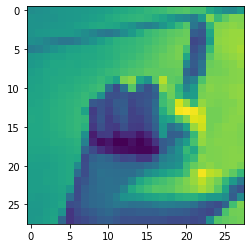

In [7]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('./data2/1.jpg')#, cv2.IMREAD_GRAYSCALE
img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
img = img / 255
                     
#Show the image with matplotlib
plt.imshow(img_gray)
plt.show()


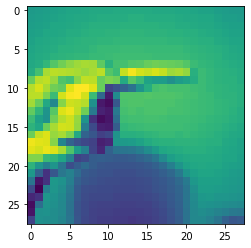

In [73]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('./data2/64.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
# img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
img = cv2.flip(img, 1)
img = img / 255
                     
#Show the image with matplotlib
plt.imshow(img)
plt.show()


In [74]:
chars = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'K',
    10: 'L',
    11: 'M',
    12: 'N',
    13: 'O',
    14: 'P',
    15: 'Q',
    16: 'R',
    17: 'S',
    18: 'T',
    19: 'U',
    20: 'V',
    21: 'W',
    22: 'X',
    23: 'Y'
}


predicted_index = np.argmax(model.predict(img.reshape((-1, 28, 28, 1))))
print(model.predict(img.reshape((-1, 28, 28, 1))))
# chr(ord('A')+ predicted_index)
chars[predicted_index]

[[2.3753937e-08 2.3789852e-04 6.6238177e-01 1.9600616e-10 7.9918220e-07
  1.8389150e-05 2.1681038e-01 9.3827330e-02 2.1251323e-10 3.6964570e-07
  2.6362663e-04 4.9325812e-04 1.4764566e-06 2.4088318e-05 8.1268465e-03
  9.8072011e-03 4.5600280e-04 8.7035162e-10 4.3681176e-08 7.0328237e-03
  5.6484805e-06 7.2412790e-06 2.4490961e-04 2.5991825e-04 4.1072746e-11]]


'C'